### Predict Sahel Rainfall with CICMoD dataset

In this project we work with **C**limate **I**ndex **C**ollection based on **Mo**del **D**ata (CICMoD) dataset (https://github.com/MarcoLandtHayen/climate_index_collection) to predict Sahel Precipitation anomalies ("Sahel rainfall").

This work is inspired by [Badr et al., 2014](https://doi.org/10.1175/JAMC-D-13-0181.1): They tried to predict summertime (July–September) Sahel rainfall anomalies using indices of springtime (April–June) sea-surface temperature (SST) and sea air temperature (SAT) anomalies. Principal component analysis was used to remove multicollinearity between predictor variables.

To follow this approach, we use **April to June mean index values as predictors** to predict **July to September seasonal sum of Sahel precipitation anomaly index**. In the first attempt we omit applying principal component analysis. And, opposed to [Badr et al., 2014], we include sea-surface salinity (SSS) anomalies as additional input feature.

**Outline in this experiment:**
- Start with **MLP model** in a **single-run experiment**.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    Conv1D,
    MaxPooling1D,
    Dropout,
    Flatten,
    BatchNormalization,
    LeakyReLU,
    concatenate,
)
from tensorflow.keras.optimizers import (
    SGD,
    Adam,
)
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from cicmod_application.preprocessing import split_sequence

from numpy.testing import assert_allclose, assert_almost_equal

### Load data

Load collection of climate indices directly from GitHub release.

In [2]:
data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2022.09.09.1/climate_indices.csv"
)
climind = pd.read_csv(data_url)

# Set index: Month BEFORE year, since we want to group by month and get seasonal mean / sum for each year.
climind = climind.set_index(["model","month","year","index"]).unstack(level=-1)["value"]
climind

index                  AMO   ENSO_12    ENSO_3   ENSO_34    ENSO_4    NAO_PC  \
model month year                                                               
CESM  1     1    -0.045584  0.878723  1.793537  2.277095  1.539571  1.494980   
            2     0.065762 -0.369939 -0.411301 -0.604617 -0.543775 -0.472225   
            3     0.093188 -0.273633  0.175905  0.360535  0.817109  0.625345   
            4     0.100560  1.645187  2.363455  2.109603  1.037441 -1.710669   
            5     0.006717 -0.298098 -1.259673 -1.511350 -1.404290 -1.297533   
...                    ...       ...       ...       ...       ...       ...   
FOCI  12    996  -0.045785 -0.226950 -0.837139 -1.329104 -1.767935 -2.489885   
            997  -0.140739  0.336926  0.372891  0.363424  0.289976 -2.476904   
            998  -0.031140 -0.168636  0.051378  0.228499  0.604563 -0.320422   
            999   0.049995  0.103462  0.036816 -0.182372 -0.070128  0.353078   
            1000 -0.006059  0.284155  0.622142  1.097104  1.292274 -0.762554   

index               NAO_ST        NP    PDO_PC  PREC_SAHEL  ...   SSS_ENA  \
model month year                                            ...             
CESM  1     1     1.571751 -0.624027  0.354552   -0.000226  ...  0.377755   
            2    -0.918063 -0.426188  1.186967   -0.002682  ...  0.006887   
            3    -0.391640 -1.888244  0.922896    0.009889  ... -0.138440   
            4    -2.133493  0.272794  1.263296    0.000170  ... -0.563790   
            5    -3.603766  0.062115  0.092897    0.005747  ...  0.187125   
...                    ...       ...       ...         ...  ...       ...   
FOCI  12    996  -3.539256  0.067635  0.916682   -0.004333  ...  0.738453   
            997  -3.147132 -0.041524  0.700469   -0.006278  ...  0.020022   
            998  -0.936924  1.923619  0.455950   -0.003692  ...  0.373719   
            999   0.325810  0.536015 -0.957125    0.002825  ... -0.243904   
            1000 -0.685174  0.324010 -0.595900    0.072165  ... -0.616161   

index               SSS_NA    SSS_SA   SSS_WNA  SST_ESIO  SST_HMDR   SST_MED  \
model month year                                                               
CESM  1     1     0.361125 -0.650658  0.001022  0.483008  0.070793  0.032231   
            2    -0.168227  0.060719 -0.216479 -0.462306  0.053236  0.071033   
            3    -0.175914 -0.342111 -0.563534 -0.098334  0.124467  0.105941   
            4    -0.535536  0.197418 -0.339864  0.492548  0.269565 -0.064848   
            5     0.112920  1.331708 -0.346535 -0.213615  0.048541  0.020526   
...                    ...       ...       ...       ...       ...       ...   
FOCI  12    996   0.437155 -0.492879  0.430365 -0.447537 -0.246611 -0.008032   
            997  -0.148237 -1.521807 -0.006727  0.356411 -0.426511  0.110487   
            998   0.342083 -0.538377  0.677175  0.408447 -0.253021  0.047124   
            999  -0.287265 -0.902391  0.508716  0.101377 -0.047944  0.089229   
            1000 -0.049702  0.477039  0.880939  0.191145 -0.241239  0.089911   

index              SST_TNA   SST_TSA  SST_WSIO  
model month year                                
CESM  1     1     0.038024  0.526206 -0.316788  
            2     0.109987  0.040107  0.149966  
            3     0.099277  0.042799  0.057675  
            4     0.320109  0.193464  0.290959  
            5     0.021310 -0.064859  0.212626  
...                    ...       ...       ...  
FOCI  12    996  -0.287892  0.067875  0.287778  
            997  -0.517072  0.046964 -0.140483  
            998  -0.286908 -0.091635  0.071905  
            999  -0.052815 -0.065626  0.202035  
            1000 -0.279017  0.093415 -0.048286  

[23988 rows x 29 columns]

### Aggregate data

Need only **April to June mean index values as predictors** to predict **July to September seasonal sum of Sahel precipitation anomaly index**.

In [3]:
# Separate data by model:
climind_FOCI = climind.loc[('FOCI')]
climind_CESM = climind.loc[('CESM')]

## Aggregate data to have April to June mean AND July to September sum:

# FOCI
climind_FOCI_AMJ_mean = climind_FOCI.loc[4:6].groupby('year').mean()
climind_FOCI_JAS_sum = climind_FOCI.loc[7:9].groupby('year').sum()

# CESM
climind_CESM_AMJ_mean = climind_CESM.loc[4:6].groupby('year').mean()
climind_CESM_JAS_sum = climind_CESM.loc[7:9].groupby('year').sum()

# From AMJ mean values select all columns except 'PREC_SAHEL', since it is used as target:
climind_FOCI_AMJ_mean = climind_FOCI_AMJ_mean.loc[:, climind_FOCI_AMJ_mean.columns != 'PREC_SAHEL']
climind_CESM_AMJ_mean = climind_CESM_AMJ_mean.loc[:, climind_CESM_AMJ_mean.columns != 'PREC_SAHEL']

# From JAS sum values select only column 'PREC_SAHEL', which is used as target:
prec_sahel_FOCI_JAS = climind_FOCI_JAS_sum.loc[:, climind_FOCI_JAS_sum.columns == 'PREC_SAHEL']
prec_sahel_CESM_JAS = climind_CESM_JAS_sum.loc[:, climind_CESM_JAS_sum.columns == 'PREC_SAHEL']

### Normalize data

Make sure that all seasonal mean indices used as predictors have **zero mean** and **unit variance**.

In [4]:
# Subtract mean and divide by standard deviation:
climind_FOCI_AMJ = (
    (climind_FOCI_AMJ_mean - np.mean(climind_FOCI_AMJ_mean,axis=0)) / 
    np.std(climind_FOCI_AMJ_mean,axis=0)
)
climind_CESM_AMJ = (
    (climind_CESM_AMJ_mean - np.mean(climind_CESM_AMJ_mean,axis=0)) / 
    np.std(climind_CESM_AMJ_mean,axis=0)
)

## Check result:
# FOCI mean == 0
assert_allclose(
    actual=np.mean(climind_FOCI_AMJ,axis=0).values, 
    desired=np.zeros(len(np.mean(climind_FOCI_AMJ,axis=0).values)), 
    atol=1e-3
)
# FOCI std == 1
assert_allclose(
    actual=np.std(climind_FOCI_AMJ,axis=0).values, 
    desired=np.ones(len(np.mean(climind_FOCI_AMJ,axis=0).values)), 
    atol=1e-3
)
# CESM mean == 0
assert_allclose(
    actual=np.mean(climind_CESM_AMJ,axis=0).values, 
    desired=np.zeros(len(np.mean(climind_CESM_AMJ,axis=0).values)), 
    atol=1e-3
)
# CESM std == 1
assert_allclose(
    actual=np.std(climind_CESM_AMJ,axis=0).values, 
    desired=np.ones(len(np.mean(climind_CESM_AMJ,axis=0).values)), 
    atol=1e-3
)

### Plot target: Sahel Rainfall anomalies JAS (sum)

In [5]:
# Define function to specify bar color, according to sign of values:
def bar_color(data,color_pos,color_neg):
    return np.where(data.values>0,color_pos,color_neg).T

Text(0, 0.5, 'norm. Anomaly (CESM)')

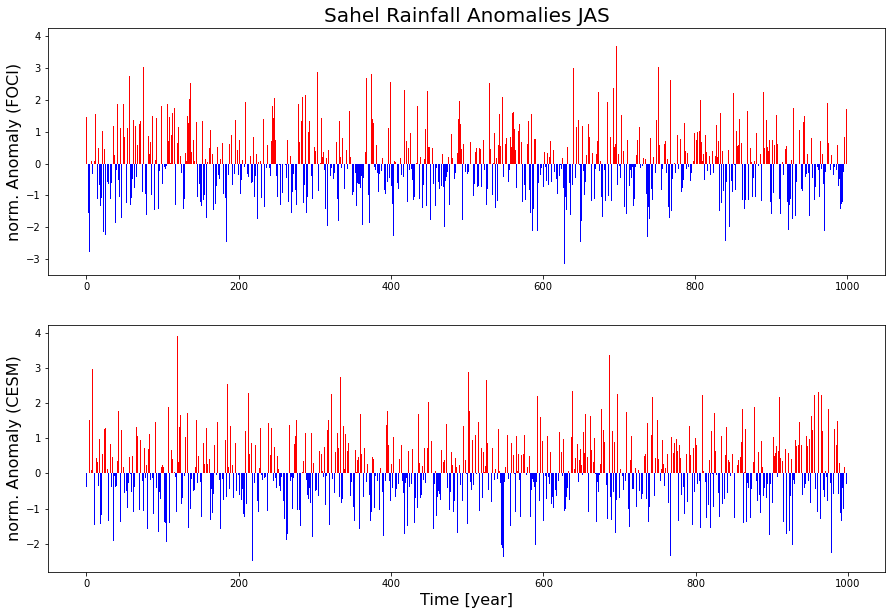

In [6]:
fig, axes = plt.subplots(2,1,figsize=[15,10])
axes[0].bar(
    x=range(len(prec_sahel_FOCI_JAS.values[:,0])),
    height=prec_sahel_FOCI_JAS.values[:,0],
    color=bar_color(prec_sahel_FOCI_JAS,'r','b')[0]
)
axes[1].bar(
    x=range(len(prec_sahel_CESM_JAS.values[:,0])),
    height=prec_sahel_CESM_JAS.values[:,0],
    color=bar_color(prec_sahel_CESM_JAS,'r','b')[0]
)
axes[0].set_title('Sahel Rainfall Anomalies JAS', fontsize=20)
axes[1].set_xlabel('Time [year]', fontsize=16)
axes[0].set_ylabel('norm. Anomaly (FOCI)', fontsize=16)
axes[1].set_ylabel('norm. Anomaly (CESM)', fontsize=16)

### Prepare inputs and targets

In [7]:
## Split inputs and targets into train and validation sets (80:20):

# Get split point:
split = int(len(climind_FOCI_AMJ) * 0.8)

train_input_FOCI = climind_FOCI_AMJ[:split]
val_input_FOCI = climind_FOCI_AMJ[split:]
train_input_CESM = climind_CESM_AMJ[:split]
val_input_CESM = climind_CESM_AMJ[split:]

train_target_FOCI = prec_sahel_FOCI_JAS[:split]
val_target_FOCI = prec_sahel_FOCI_JAS[split:]
train_target_CESM = prec_sahel_CESM_JAS[:split]
val_target_CESM = prec_sahel_CESM_JAS[split:]

# Check dimensions:
print("train_input_FOCI shape (samples, features): ", train_input_FOCI.shape)
print("train_input_CESM shape (samples, features): ", train_input_CESM.shape)
print("val_input_FOCI shape (samples, features): ", val_input_FOCI.shape)
print("val_input_CESM shape (samples, features): ", val_input_CESM.shape)
print("\ntrain_target_FOCI shape (samples, features): ", train_target_FOCI.shape)
print("train_target_CESM shape (samples, features): ", train_target_CESM.shape)
print("val_target_FOCI shape (samples, features): ", val_target_FOCI.shape)
print("val_target_CESM shape (samples, features): ", val_target_CESM.shape)

train_input_FOCI shape (samples, features):  (800, 28)
train_input_CESM shape (samples, features):  (800, 28)
val_input_FOCI shape (samples, features):  (200, 28)
val_input_CESM shape (samples, features):  (199, 28)

train_target_FOCI shape (samples, features):  (800, 1)
train_target_CESM shape (samples, features):  (800, 1)
val_target_FOCI shape (samples, features):  (200, 1)
val_target_CESM shape (samples, features):  (199, 1)


### Set up multi-layer perceptron (MLP) for single run experiments on FOCI and CESM data

In [31]:
# Define customized metric function to compute Pearson's correlation coefficient 
# on true targets and model predictions.

def correlation_coefficient(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    sx = K.std(x)
    xy = K.std(y)
    xm, ym = x-mx, y-my
    r = K.mean(xm * ym) / (sx * sy)
    return r

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense_25 (Dense)             (None, 20)                580       
_________________________________________________________________
dense_26 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 11        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
80/80 - 0s - loss: 3.0022 - correlation_coefficient: -7.7918e-02 - val_loss: 1.6140 - val_correlation_coefficient: 0.2204
Epoch 2/10
80/80 - 0s - loss: 1.5637 - correlation_coefficient: 0.2083 - val_loss: 1.0947 - val_correlation_coefficient: 0.3338
Ep

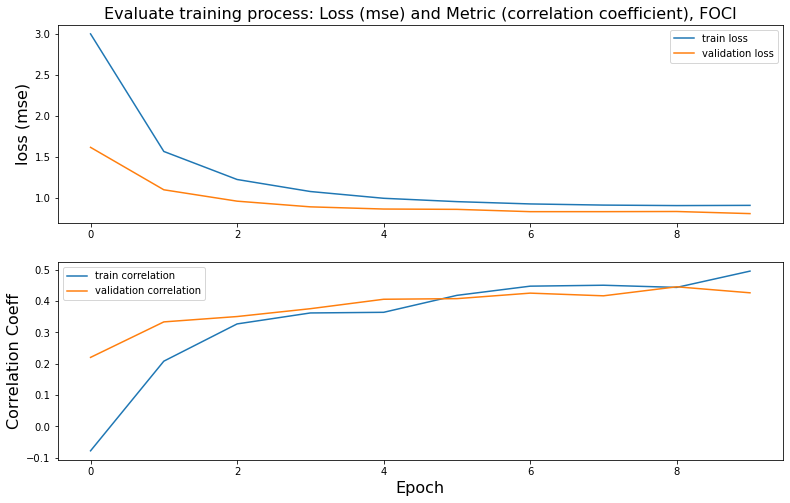

In [61]:
## Set parameters upfront:
lr = 0.0005 # Learning rate
epc = 10 # Number of epochs
batch_size = 10 # Batch size
in_features = train_input_FOCI.shape[1] # Number of input features

# Set up layers:
inputs = Input(shape=(in_features))
hidden_1 = Dense(20, activation='linear')(inputs)
hidden_2 = Dense(10, activation='linear')(hidden_1)
output = Dense(1, activation='linear')(hidden_2)

# Define and compile model :
model_MLP = Model(inputs, output, name='MLP')
opt = Adam(lr=lr) #SGD(lr=lr)
model_MLP.compile(loss='mse', optimizer=opt, metrics=[correlation_coefficient])
model_MLP.summary()

## train model on FOCI data:
history = model_MLP.fit(train_input_FOCI, train_target_FOCI, epochs=epc, verbose=2, shuffle=True,
                    batch_size=batch_size, validation_data=(val_input_FOCI, val_target_FOCI))

# Plot loss (mse) and metric (correlation coefficient) on train and validation data (FOCI):
fig, axes = plt.subplots(2, 1, figsize=(13,8))
axes[0].set_title("Evaluate training process: Loss (mse) and Metric (correlation coefficient), FOCI", fontsize=16)
axes[0].plot(history.history['loss'], label='train loss'), 
axes[0].plot(history.history['val_loss'], label='validation loss')
axes[0].set_ylabel("loss (mse)", fontsize=16)
axes[0].legend()
axes[1].plot(history.history['correlation_coefficient'], label='train correlation'), 
axes[1].plot(history.history['val_correlation_coefficient'], label='validation correlation')
axes[1].set_ylabel("Correlation Coeff", fontsize=16)
axes[1].legend()
axes[1].set_xlabel("Epoch", fontsize=16)
plt.show()

## Get model predictions on train and validation data:
train_pred_MLP_FOCI = model_MLP.predict(train_input_FOCI)
val_pred_MLP_FOCI = model_MLP.predict(val_input_FOCI)

Text(0, 0.5, 'norm. Anomaly (FOCI)')

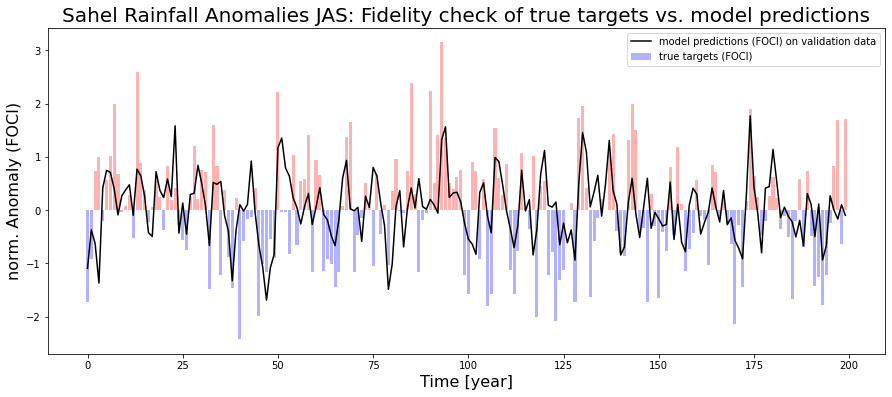

In [62]:
# Fidelity check: Plot VALIDATION targets as bar plot (red / blue) vs. predictions as black line (FOCI)
fig, ax = plt.subplots(1,1,figsize=[15,6])
ax.bar(
    x=range(len(prec_sahel_FOCI_JAS.values[split:,0])),
    height=prec_sahel_FOCI_JAS.values[split:,0],
    color=bar_color(prec_sahel_FOCI_JAS[split:],'r','b')[0],
    label="true targets (FOCI)",
    alpha=0.3
)
ax.plot(val_pred_MLP_FOCI, label="model predictions (FOCI) on validation data", color='black')
ax.legend()
ax.set_title('Sahel Rainfall Anomalies JAS: Fidelity check of true targets vs. model predictions', fontsize=20)
ax.set_xlabel('Time [year]', fontsize=16)
ax.set_ylabel('norm. Anomaly (FOCI)', fontsize=16)

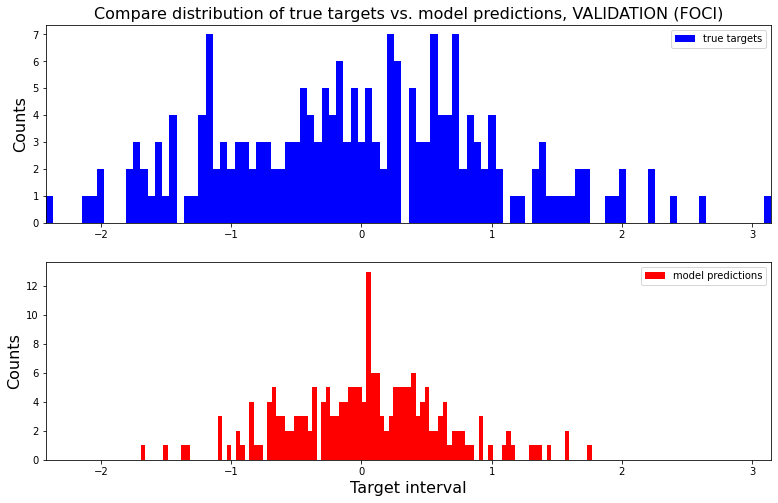

In [63]:
# Plot histogram of true targets and predictions (FOCI)
nBins = 100
fig, axes = plt.subplots(2, 1, figsize=(13,8))
axes[0].hist(val_target_FOCI.values[:,0], nBins, color="blue", label="true targets")
axes[0].set_ylabel("Counts", fontsize=16)
axes[0].legend()
axes[0].set_xlim(left=min(val_target_FOCI.values[:,0]), right=max(val_target_FOCI.values[:,0]))
axes[1].hist(val_pred_MLP_FOCI[:,0], nBins, color="red", label="model predictions")
axes[1].set_ylabel("Counts", fontsize=16)
axes[1].legend()
axes[1].set_xlim(left=min(val_target_FOCI.values[:,0]), right=max(val_target_FOCI.values[:,0]))
axes[1].set_xlabel("Target interval", fontsize=16)
axes[0].set_title("Compare distribution of true targets vs. model predictions, VALIDATION (FOCI)", fontsize=16)
plt.show()

In [64]:
# Check correlation of true targets and model predictions:
print("Correlation on train data (FOCI): ",
      np.round(np.corrcoef(np.stack([train_pred_MLP_FOCI[:,0], train_target_FOCI.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (FOCI): ",
      np.round(np.corrcoef(np.stack([val_pred_MLP_FOCI[:,0], val_target_FOCI.values[:,0]]))[0,1],3)
     )

Correlation on train data (FOCI):  0.537
Correlation on validation data (FOCI):  0.507


### Discussion on single-run experiment with MLP to predict Sahel Rainfall

#### Setup
- In this experiment we used all indices from our CICMoD dataset as predictors, except Sahel Rainfall anomaly ("PREC_SAHEL"), since it was used as target.
- Normalized input indicies.
- Trained multi-layer perceptron with two hidden layers with mean-squared-error loss and tracked correlation coefficient of true targets and model predictions as customized metric.

#### Results
Started to train model on FOCI data. The model is found to train well, no signs of overfitting. Adding a third hidden layer didn't improve model performance. Find somewhat poor correlation of about 50% on both - train and validation data. (--> Compare to [Badr et al., 2014])

#### Next steps
- Try to train model on CESM data.
- Try to cross model an data: Can we train a model on e.g. FOCI data and apply it to CESM data?
- Perform multi-run experiments to optimize model (hyper-)parameters.
- Try layer-wise relevance propagation.